In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.experimental import enable_halving_search_cv
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import plotly.express as px

from sklearn import set_config
set_config("diagram")

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load Banking Data set
df = pd.read_csv('data/bank-additional-full.csv', delimiter=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Data Preparation

In [5]:
# Create a copy of data frame to keep the source intact.
df_copy = df.copy()

# We can remove last contact details 
df_copy = df_copy.drop(columns=["month", "day_of_week"])

# Convert 'yes'/'no' to int fields.
df_copy['housing'] = df['housing'].replace({'yes':1, 'no': 0, 'unknown': 0 })
df_copy['default'] = df['default'].replace({'yes':1, 'no': 0, 'unknown': 0 } )
df_copy['loan'] = df['loan'].replace({'yes':1, 'no': 0 , 'unknown': 0 })
df_copy['y'] = df['y'].replace({'yes':1, 'no': 0, 'unknown': 0 } )

#Do label encoding for categorical values
cateogry_columns = ['job', 'marital', 'education', 'contact', 'poutcome']

label_encoder = LabelEncoder()
for col in cateogry_columns:
    df_copy[col] = label_encoder.fit_transform(df[col])

df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  int64  
 2   marital         41188 non-null  int64  
 3   education       41188 non-null  int64  
 4   default         41188 non-null  int64  
 5   housing         41188 non-null  int64  
 6   loan            41188 non-null  int64  
 7   contact         41188 non-null  int64  
 8   duration        41188 non-null  int64  
 9   campaign        41188 non-null  int64  
 10  pdays           41188 non-null  int64  
 11  previous        41188 non-null  int64  
 12  poutcome        41188 non-null  int64  
 13  emp.var.rate    41188 non-null  float64
 14  cons.price.idx  41188 non-null  float64
 15  cons.conf.idx   41188 non-null  float64
 16  euribor3m       41188 non-null  float64
 17  nr.employed     41188 non-null 

### Analysis

   Subscription  counts  percentage
0             0   36548   88.734583
1             1    4640   11.265417


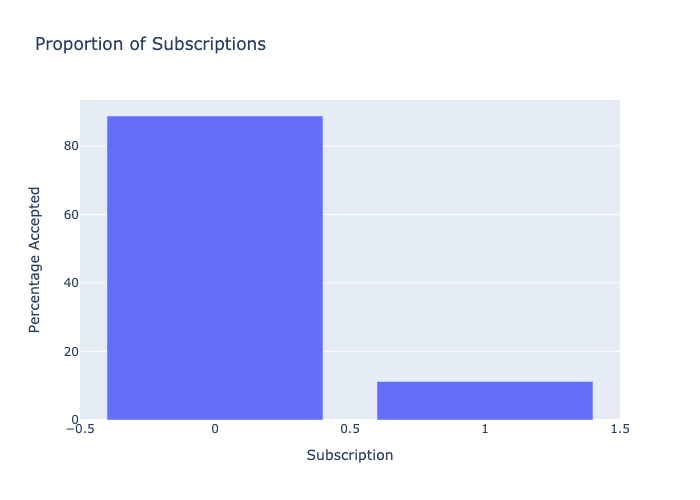

In [6]:
# Compute Bar coupon acceptance ratio
deposit_subscriptions = df_copy["y"].value_counts().reset_index()
deposit_subscriptions.columns = ['Subscription', 'counts']
deposit_subscriptions["percentage"] =  (deposit_subscriptions['counts'] / deposit_subscriptions['counts'].sum()) * 100
print(deposit_subscriptions)

# Plot using a bar chart
fig = px.bar(deposit_subscriptions, x="Subscription", y ="percentage",
    labels={"index": "Subscription", "percentage": "Percentage Accepted"},
        title="Proportion of Subscriptions")
fig.show("png")

In [7]:
# Split the dataset into features and target variable
X = df_copy.drop('y', axis=1)
y = df_copy['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the numeric values.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Evaluation

In [ ]:
models = [GridSearchCV(KNeighborsClassifier(), 
                        param_grid={'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}, cv=5),
          GridSearchCV(LogisticRegression(), param_grid={'C': [0.1, 1, 10],'solver': ['liblinear', 'lbfgs'],
                                                         'max_iter': [100, 1000, 10000]}, cv=5),
          GridSearchCV(DecisionTreeClassifier(), param_grid={'max_depth': [None, 5, 10]}, cv=5),
          GridSearchCV(SVC(), param_grid={'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],'gamma': [0.1, 1.0]}, cv=5)
         ]




In [ ]:
grid_names = ["Logistic Regression", "Decision Tree", "KNN", "SVC"]
grids = [ GridSearchCV( LogisticRegression(), {'C': [0, 1,1,10]}),
          GridSearchCV( DecisionTreeClassifier(), {'max_depth': [None, 3,5,7,15]}),
         GridSearchCV( KNeighborsClassifier(), {'n_neighbors': [3,5,7,10]}),
         GridSearchCV(SVC(), {'kernel': ['rbf','poly','linear','sigmoid'], 'gamma': [0.1,1.8,10.0,100.0]})
        ]

for i in range( 0, len(grids) ):
    model = grids[i].fit( X_train_scaled, y_train)
    train_score = model.best_estimator_.score( X_train_scaled, y_train )
    test_score = model.best_estimator_.score( X_test_scaled, y_test )
    fit_time = model.cv_results_["mean_fit_time"].sum()
    score_time = model.cv_results_["mean_score_time"].sum()
    print(f' {grid_names[i]}: test_score: {test_score}, train_score: {train_score}, fit time: {fit_time}, score time: {score_time}')

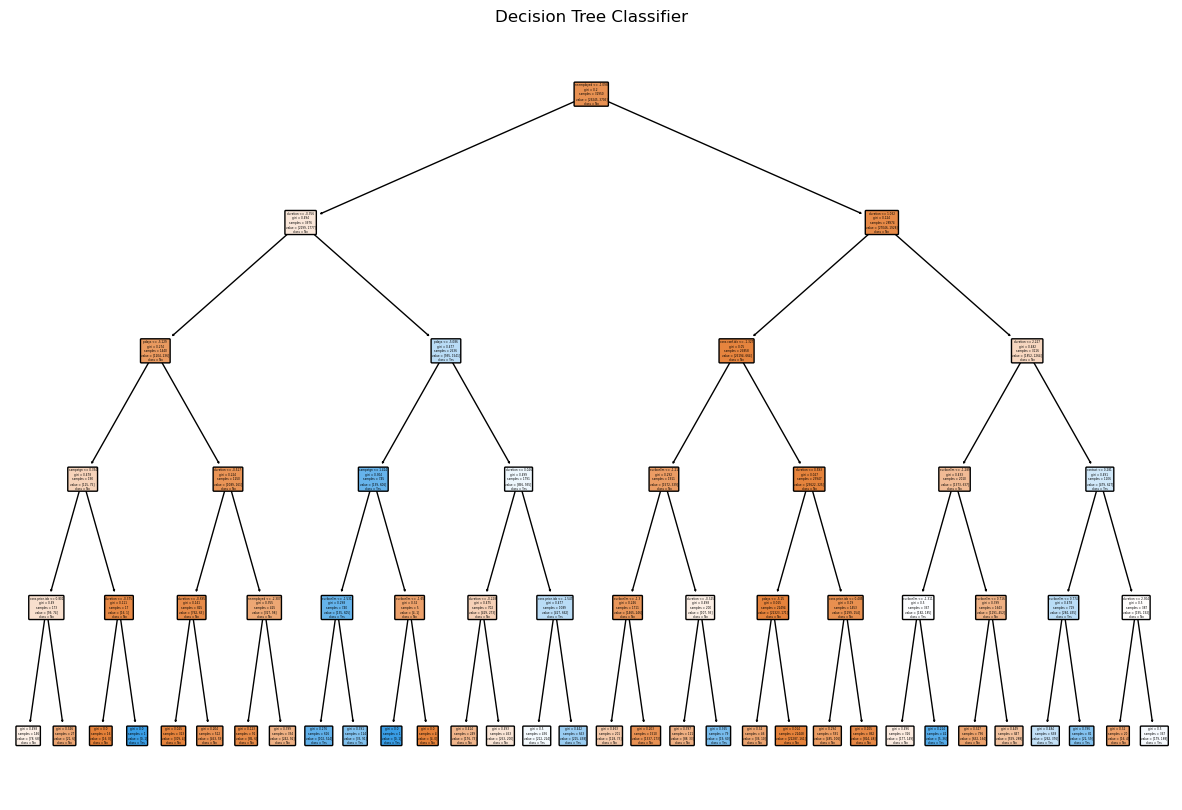

In [9]:
# Digging more on Decision Tree Classifier.

tree_grid = GridSearchCV(DecisionTreeClassifier(), param_grid={'max_depth': [None, 5, 10]}, cv=5).fit( X_train_scaled, y_train)
tree = DecisionTreeClassifier(**tree_grid.best_params_).fit(X_train_scaled, y_train)

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(tree, feature_names=X.columns, class_names=['No', 'Yes'], filled=True, rounded=True)
plt.title('Decision Tree Classifier')
plt.show()

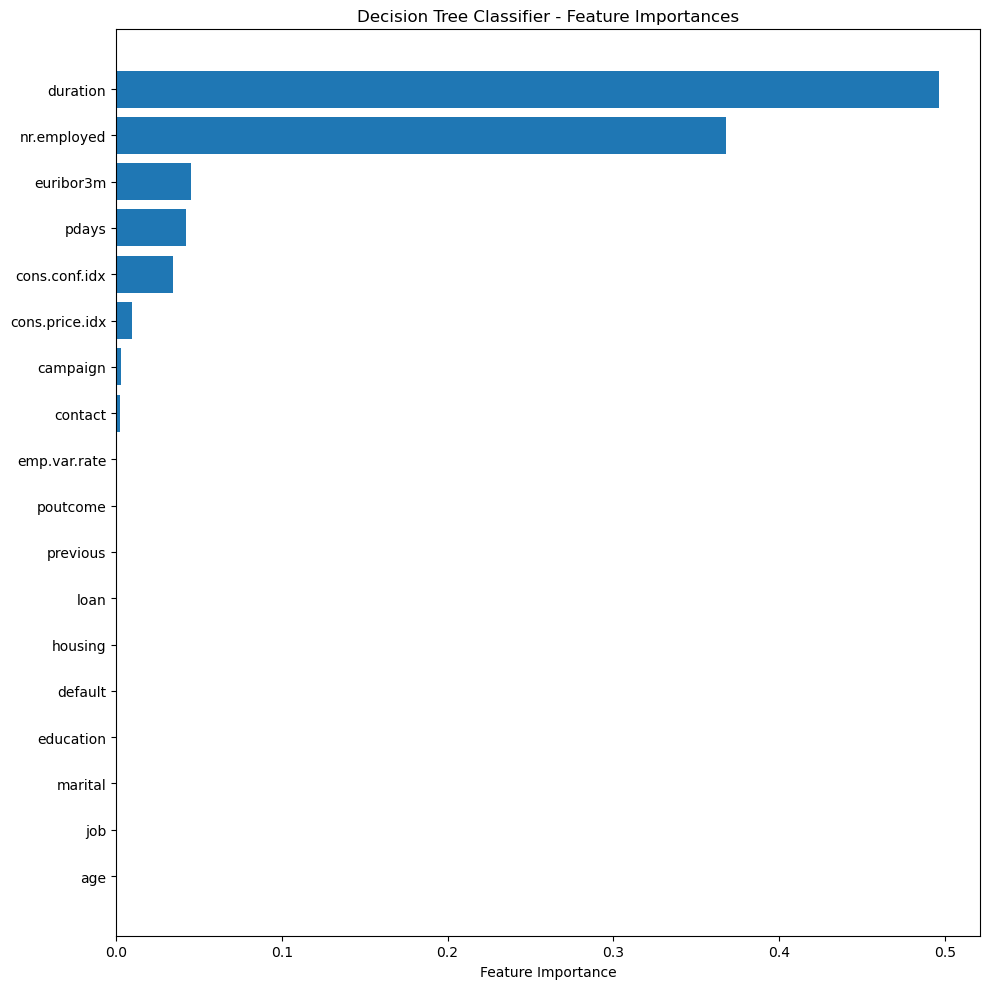

In [10]:
# Get feature importances from the decision tree model
feature_importances = tree.feature_importances_
sorted_idx = np.argsort(feature_importances)

# Create a horizontal bar plot for feature importances
plt.figure(figsize=(10, 10))
plt.barh(range(X.shape[1]), feature_importances[sorted_idx], align='center')
plt.yticks(range(X.shape[1]), X.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Decision Tree Classifier - Feature Importances')
plt.tight_layout()
plt.show()

In [11]:
tree_grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid={'max_depth': [None, 5, 10],'ccp_alpha': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]}, cv=5).fit(X_train_scaled, y_train)
dtree_pruned = DecisionTreeClassifier(max_depth=None,ccp_alpha = 0.001).fit(X_train_scaled, y_train)

y_train_pred = dtree_pruned.predict(X_train_scaled)
y_test_pred = dtree_pruned.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(train_accuracy)
print(test_accuracy)


0.9133535660091047
0.9126001456664239


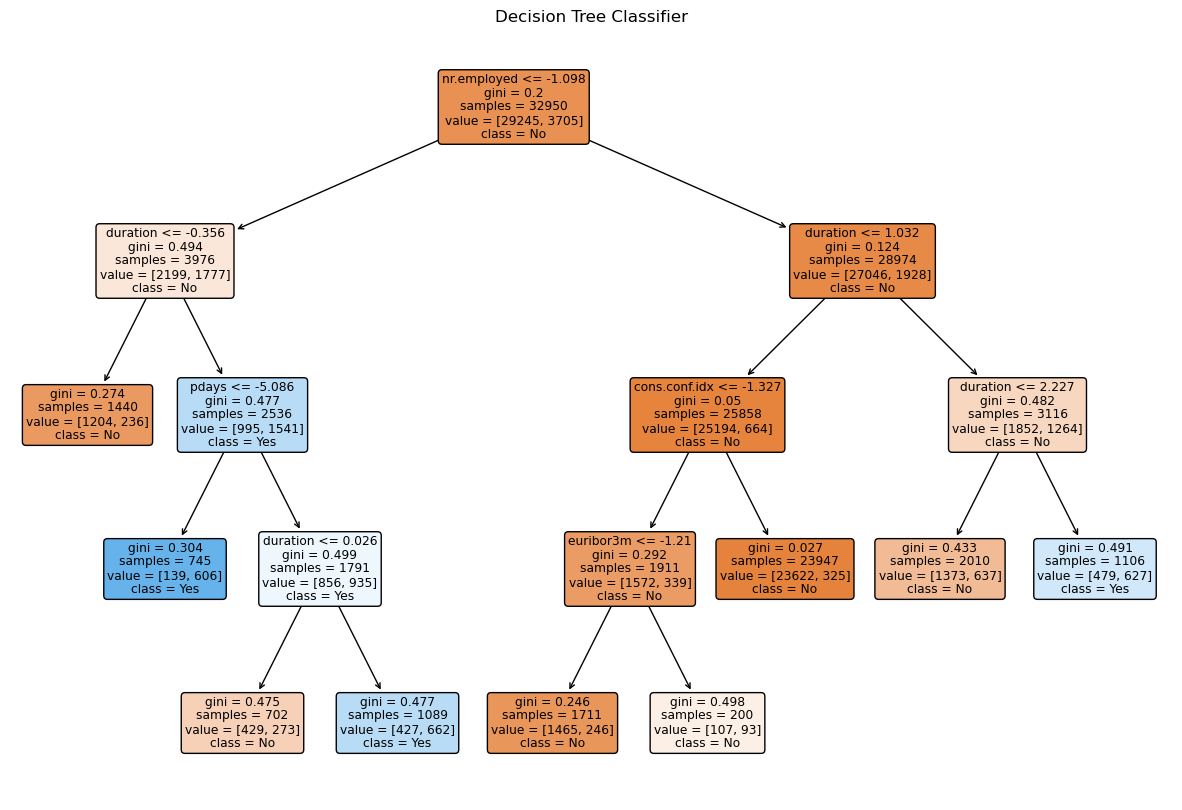

In [20]:
# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(dtree_pruned, feature_names=X.columns, class_names=['No', 'Yes'], filled=True, rounded=True)
plt.title('Decision Tree Classifier')
plt.show()

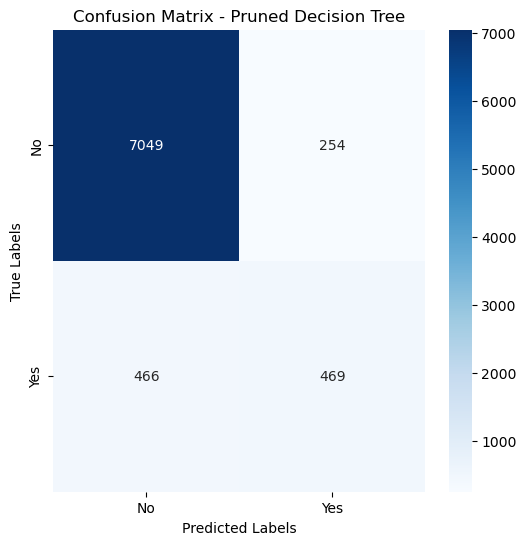

In [15]:
# Checking the confusion matrix

# Make predictions on the test set using the pruned decision tree model
y_pred = dtree_pruned.predict(X_test_scaled)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix - Pruned Decision Tree')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [24]:
#Calculating the metrics for the decision tree classifier model

# accuracy
accuracy = accuracy_score(y_test, y_pred)

# precision
precision = precision_score(y_test, y_pred, pos_label=1)

# recall (sensitivity)
recall = recall_score(y_test, y_pred, pos_label=1)

# F1-score
f1 = f1_score(y_test, y_pred, pos_label=1)

# Balanced Accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC-AUC score 
y_prob = dtree_pruned.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Accuracy: 0.9126
Precision: 0.6487
Recall (Sensitivity): 0.5016
F1-Score: 0.5657
Balanced Accuracy: 0.7334
ROC-AUC Score: 0.9019
